In [1]:
!wget https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv

--2020-05-10 15:51:38--  https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23873 (23K) [text/plain]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>]  23.31K  --.-KB/s    in 0.01s   

2020-05-10 15:51:38 (1.89 MB/s) - ‘diabetes.csv’ saved [23873/23873]



In [0]:
with open("diabetes.csv", "r") as f:
    data = f.readlines()
feats = data[0]
feats = feats.replace('\n','')
feats = feats.split(",")

In [0]:
feats = feats[0:(len(feats)-1)]	
alldat = []				
alllabs = []			
for i in range(1,len(data)):	
     line = data[i]		
     line = line.replace('\n','')		
     csvline = line.split(",")		
     alllabs = alllabs + [int(csvline[len(csvline)-1])]
     csvline = [float(csvline[i]) for i in range(len(csvline)-1)]
     alldat = alldat + [csvline]		

In [0]:
import random

trainmask = [random.randint(0,2) for i in range(len(alldat))]

traindat = [alldat[i] for i in range(len(alldat)) if trainmask[i]]
trainlabs = [alllabs[i] for i in range(len(alldat)) if trainmask[i]]
testdat = [alldat[i] for i in range(len(alldat)) if not trainmask[i]]
testlabs = [alllabs[i] for i in range(len(alldat)) if not trainmask[i]]

In [5]:
len(traindat)

514

In [0]:
from sklearn import tree

testerr = []
trainerr = []
nleaves = range(2,30)

for n in nleaves:
  clf = tree.DecisionTreeClassifier(max_leaf_nodes = n)	
  clf = clf.fit(traindat, trainlabs)
  
  pred = clf.predict(traindat)
  trainerr += [sum([pred[i] != trainlabs[i] for i in range(len(trainlabs))]) / len(trainlabs)]
  pred = clf.predict(testdat)
  testerr += [sum([pred[i] != testlabs[i] for i in range(len(testlabs))]) / len(testlabs)]


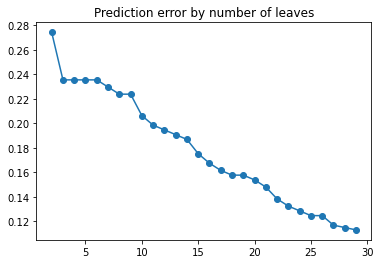

In [7]:
import matplotlib.pyplot as plt

plt.scatter(nleaves, trainerr)
plt.plot(nleaves, trainerr)
plt.title('Prediction error by number of leaves')
plt.show()

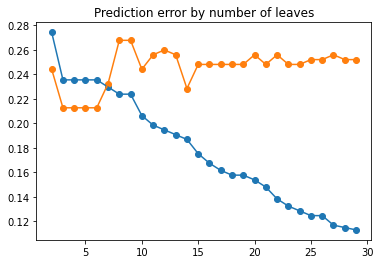

In [8]:
import matplotlib.pyplot as plt

plt.scatter(nleaves, trainerr)
plt.plot(nleaves, trainerr)
plt.scatter(nleaves, testerr)
plt.plot(nleaves, testerr)
plt.title('Prediction error by number of leaves')
plt.show()

In [0]:
import math

testerr = []
minierr = []
ms = [math.ceil(len(traindat) * (i+1)/10) for i in range(10)]
# actualms = []
repeats = 20

for m in ms:
  minitotal = 0
  testtotal = 0
  for r in range(repeats):
    minimask = [random.randint(0,len(traindat)-1) <= m for i in range(len(traindat))]
    minidat = [traindat[i] for i in range(len(traindat)) if minimask[i]]
    minilabs = [trainlabs[i] for i in range(len(traindat)) if minimask[i]]
    clf = tree.DecisionTreeClassifier(max_leaf_nodes = 5)	
    clf = clf.fit(minidat, minilabs)
    pred = clf.predict(minidat)
    minitotal += sum([pred[i] != minilabs[i] for i in range(len(minilabs))]) / len(minilabs)
    pred = clf.predict(testdat)
    testtotal += sum([pred[i] != testlabs[i] for i in range(len(testlabs))]) / len(testlabs)
  minierr += [minitotal / repeats]
  testerr += [testtotal / repeats]

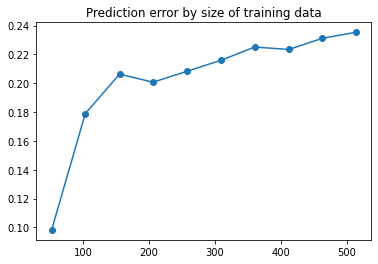

In [10]:
plt.scatter(ms, minierr)
plt.plot(ms, minierr)
plt.title('Prediction error by size of training data')
plt.show()

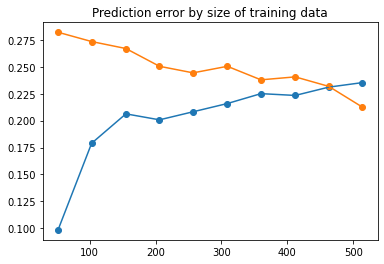

In [11]:
plt.scatter(ms, minierr)
plt.plot(ms, minierr)
plt.scatter(ms, testerr)
plt.plot(ms, testerr)
plt.title('Prediction error by size of training data')
plt.show()